In [1]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

TESTS 
- hex hex22
- benzene/ testJT
- equiv
  

Import modules

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset

from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm

from metatensor import load, sort
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase

from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
import rascaline
from mlelec.utils.pbc_utils import kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True, sort_orbs = False):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target, sort_orbs = sort_orbs)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.to(arrays='numpy')
    blocks = sort(blocks)
    blocks = blocks.to(arrays='torch')
    
    coupled_blocks = coupled_blocks.to(arrays='numpy')
    coupled_blocks = sort(coupled_blocks)
    coupled_blocks = coupled_blocks.to(arrays='torch')
    
    return blocks, coupled_blocks

/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

In [4]:
orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

In [5]:
import rascaline
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
cutoff=6
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

def compute_features(dataset, all_pairs=False):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [6]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [7]:
def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )
  
                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

    print('TARGET PASSED')
def check_gij(gij, tol = 1e-4):
    """ Similar to the checks on the target above, we can check for gij that 
        - block_type = 1 < n| gij; lambda = ODD> = 0
        - block_type = -1 <n | gij; lambda = EVEN> = 0
    (inversion sigma = 1 for all of these blocks since they are directly the SPH components)
    """ 
    for k, b in gij.items(): 
        btype= k['block_type']
        L = k['spherical_harmonics_l']
        if L%2==0 and btype==-1 : 
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')
        elif L%2==1 and btype==1:
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')

    print('gij PASSED')

In [8]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

# TODO : CHECK WHATS happening in feats wrt sorting i,j, species 

# BENZENE - test

In [9]:
import ase
frame = ase.Atoms("C6H6")
rc = 1.384
rh = 2.465
for i in range(6):
    frame.positions[i] = [np.cos(i*np.pi/3)*rc,np.sin(i*np.pi/3)*rc,0]
    frame.positions[i+6] = [np.cos(i*np.pi/3)*rh,np.sin(i*np.pi/3)*rh,0]

In [10]:
np.random.seed(321)
fock = np.random.uniform(size=(30,30))
fock = fock+fock.T
ref_eva = np.linalg.eigvalsh(fock)

In [11]:
dataset =PySCFPeriodicDataset(frames = [frame], 
                               kmesh = [1,1,1], 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kfock, 
                               # overlap_kspace = kover, 
                              fock_realspace=[fock],#[{tuple([0,0,0]):fock}],
                               device = device, 
                               orbs = orbitals['benzene'], 
                               orbs_name = None
                               )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:887: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [12]:

target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = 6, device = device, all_pairs = False)

In [13]:
# plt.matshow((dataset.fock_realspace- fock)[0])

In [14]:
# %%timeit
hfeat = compute_features(dataset)

cpu pair features
cpu single center features
cpu single center features
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species


In [15]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(658.5638)


In [16]:
fock_pred = blocks_to_matrix(pred_ridge_bias, dataset)
fock_pred = next(iter(fock_pred[0].values()))

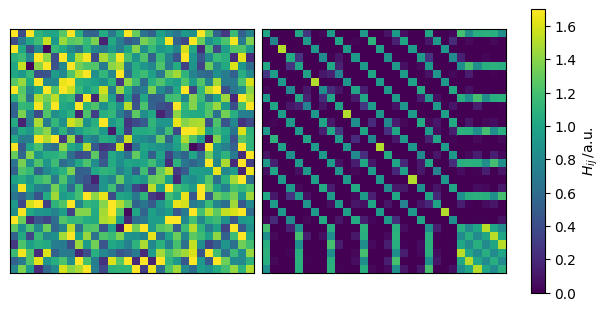

In [17]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(fock_pred, vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

3.5865086555972887
0.016273980152756308
0.5076514124395723


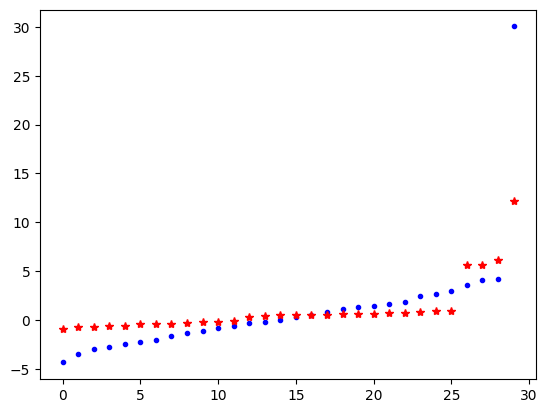

In [18]:
eva_ref = np.linalg.eigvalsh(fock)
eva_pred = np.linalg.eigvalsh(fock_pred)
plt.plot(eva_ref, 'b.')
plt.plot(eva_pred, 'r*') 
print(np.sqrt(np.mean((np.linalg.eigvalsh(fock)-np.linalg.eigvalsh(fock_pred))**2)))
print(np.linalg.eigvalsh(fock)[14])
print(np.linalg.eigvalsh(fock_pred)[14])

## displace

In [19]:
ld = np.linspace(-0.1,0.1,31)
frames_displace = []
fockdummy = []
for i,d in enumerate(ld):
    fd = frame.copy()    
    cent = fd.positions.mean(axis=0)
    fd.positions -= cent
    # q3hat
    # fd.positions[[-5,-3,-1]] *= 1+d
    # fd.positions[[-6,-4,-2]] *= 1-d
    # q2hat
    fd.positions[[-5,-2]] *= 1+d
    fd.positions[[-6,-3]] *= 1-d
    fd.positions += cent
    frames_displace.append(fd)
    fockdummy.append(np.zeros_like(fock))
    
dataset_displaced = PySCFPeriodicDataset(frames = frames_displace, 
                               kmesh = [1,1,1], 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kfock, 
                               # overlap_kspace = kover, 
                              fock_realspace=fockdummy,
                               device = device, 
                               orbs = orbitals['benzene'], 
                               orbs_name = None
                               )


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:887: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [20]:
hfeat_d = compute_features(dataset_displaced)

cpu pair features
cpu single center features
cpu single center features
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species


In [21]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:707: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [22]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp=[] 
for i in range(len(frames_displace)):
    fock_disp.append(fockd[i][0,0,0].numpy())
    # print(fock_disp[-1].shape)

In [23]:
for f in fock_disp:
    assert np.linalg.norm(f - f.T)<1e-14

In [24]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
evd = [np.linalg.eigh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

In [25]:
evd = [np.linalg.eigh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

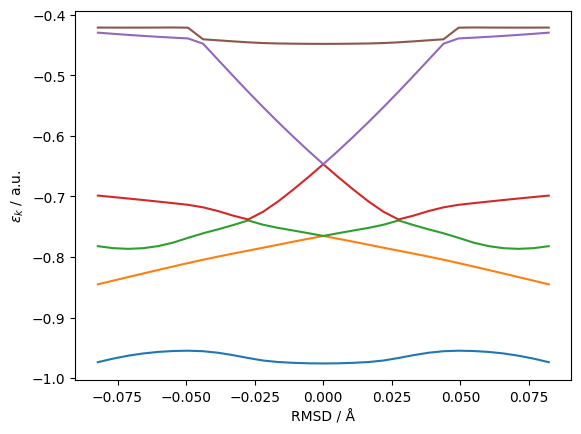

In [26]:
for k in range(0,6):
    plt.plot(dd, [evd[i][0][k] for i in range(len(ld))])   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
# plt.savefig("../figures/benzene-deformations.svg")

In [93]:
rad = {'C':0.25, 'H':0.15}
col = {'C': 'gray', 'H': 'white'}
def mo_plot(ax, mol, orbs, eve):
    cent = mol.positions.mean(axis=0)
    
    mo_xy = mo_compute(gv_xy, mol, orbs, eve, project=(1,1,0), sigma=0.25).reshape(ngrid,ngrid)
    ax.contourf(xgrid, ygrid, mo_xy, levels=[-0.01,0.01], 
                extend='both', colors=['blue','white','red'])
    
    for i in range(len(mol)):
        ax.add_patch(plt.Circle((mol.positions[i]-cent)[:2], rad[mol.symbols[i]], fill=False, ec='black' ))

[]

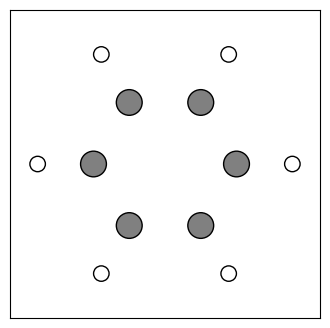

In [94]:
fig, ax = plt.subplots(figsize=(4,4))
mol = frames_displace[len(ld)//2]
cent=mol.positions.mean(axis=0)
for i in range(len(mol)):
    ax.add_patch(plt.Circle((mol.positions[i]-cent)[:2], rad[mol.symbols[i]], fc=col[mol.symbols[i]], ec='black' ))
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_xticks([])
ax.set_yticks([])

# BN

In [9]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 1
frames = read(f'{root}/BN/BN_unit_cell.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[8,8,1]]
kfock = [np.load(f"{root}/BN/fock.npy", allow_pickle = True) for i in range(START, STOP)]
kover = [np.load(f"{root}/BN/over.npy", allow_pickle = True) for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kover, 
                               fock_kspace = kfock, 
                               overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [10]:
for ALL_PAIRS in [True, False]:
    for SORT_ORBS in [True, False]:
        cutoff = 3
        kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
        rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
        for ifr in range(len(kfock)):
            for ik in range(len(kfock[ifr])):
                # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                assert (np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS)
        print(ALL_PAIRS, SORT_ORBS, 'passed')

True True passed
True False passed
False True passed
False False passed


In [11]:
cutoff = 3
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
# torch.norm(rhk[0] - dataset.fock_kspace[0])
# kblocks_o = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, target='overlap')
# rSk = kblocks_to_matrix(kblocks_o, dataset, all_pairs=ALL_PAIRS)
# 

In [712]:
from scipy.linalg import eigvalsh
eigactual = []
eigcut=[]
for ik in range(64):
    eigactual.append(eigvalsh(dataset.fock_kspace[0][ik].numpy(), dataset.overlap_kspace[0][ik].numpy()))
    eigcut.append(eigvalsh(rhk[0][ik].numpy(), rSk[0][ik].numpy()))
eigactual = np.concatenate(eigactual)
eigcut = np.concatenate(eigcut)    

(-2.0, 2.066092172255316)

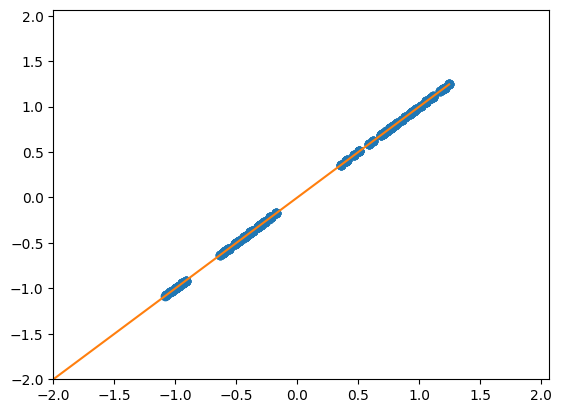

In [530]:
plt.plot(eigactual, eigcut, 'o')
plt.plot([np.min(eigactual), np.max(eigactual)],[np.min(eigactual), np.max(eigactual)])
plt.ylim(-2,)
plt.xlim(-2,)

In [14]:
# for ifr in range(len(kfock)):
#     for ik in range(len(kfock[ifr])):
#         # assert torch.norm(rhk[ifr][ik] - rhk[ifr][ik].conj().T)<1e-12
#         # assert np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T)<1e-12
#         assert np.linalg.norm(kfock[ifr][ik] -rhk[ifr][ik].numpy())<1e-12


In [20]:
cutoff = 10
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)

In [26]:
target_blocks[0].samples

Labels(
    structure  center  neighbor  cell_shift_a  cell_shift_b  cell_shift_c
        0        0        0           -4            1             0
        0        0        0           -4            2             0
        0        0        0           -4            3             0
        0        0        0           -3            -1            0
        0        0        0           -3            0             0
        0        0        0           -3            1             0
        0        0        0           -3            2             0
        0        0        0           -3            3             0
        0        0        0           -3            4             0
        0        0        0           -2            -2            0
        0        0        0           -2            -1            0
        0        0        0           -2            0             0
        0        0        0           -2            1             0
        0        0        0       

In [23]:
rht = blocks_to_matrix(target_coupled_blocks, dataset, all_pairs  =ALL_PAIRS, sort_orbs=SORT_ORBS)

In [24]:
for ifr in range(len(rht)):
    for T in rht[ifr]:
        mT = tuple(-t for t in T)
        assert torch.norm(rht[ifr][T] - rht[ifr][mT].T)<1e-12, torch.norm(rht[ifr][T] - rht[ifr][mT].T)

In [25]:
from mlelec.utils.pbc_utils import kblocks_to_matrix
kblocks = kmatrix_to_blocks(dataset, cutoff = 6, all_pairs = False)
rhk = kblocks_to_matrix(kblocks, dataset)
torch.norm(rhk[0] - dataset.fock_kspace[0])

hello tensor([[-1.6793+2.0929e-17j]])


tensor(2.8095e-14)

In [580]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
cutoff=10
spline_basis = False


hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}
LCUT=4
hfeat = compute_features(dataset, ALL_PAIRS)

cpu pair features
cpu single center features


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/features/acdc.py:147: UserWarning: The selected cutoff is less than the maximum distance as repeated for kmesh (32.0) among atoms in the system!
  warnings.warn(f"The selected cutoff is less than the maximum distance as repeated for kmesh ({np.ceil(min_cutoff)}) among atoms in the system!")


cpu single center features
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
Corresponding swapped pair not found [[ 0  0  0 -4  1  0  1]
 [ 0  0  0 -4  2  0  1]
 [ 0  0  0 -4  3  0  1]
 [ 0  0  0 -3 -1  0  1]
 [ 0  0  0 -3  0  0  1]
 [ 0  0  0 -3  1  0  1]
 [ 0  0  0 -3  2  0  1]
 [ 0  0  0 -3  3  0  1]
 [ 0  0  0 -3  4  0  1]
 [ 0  0  0 -2 -2  0  1]
 [ 0  0  0 -2 -1  0  1]
 [ 0  0  0 -2  0  0  1]
 [ 0  0  0 -2  1  0  1]
 [ 0  0  0 -2  2  0  1]
 [ 0  0  0 -2  3  0  1]
 [ 0  0  0 -2  4  0  1]
 [ 0  0  0 -1 -3  0  1]
 [ 0  0  0 -1 -2  0  1]


In [581]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -2, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/minicond

tensor(2.5692e-08)


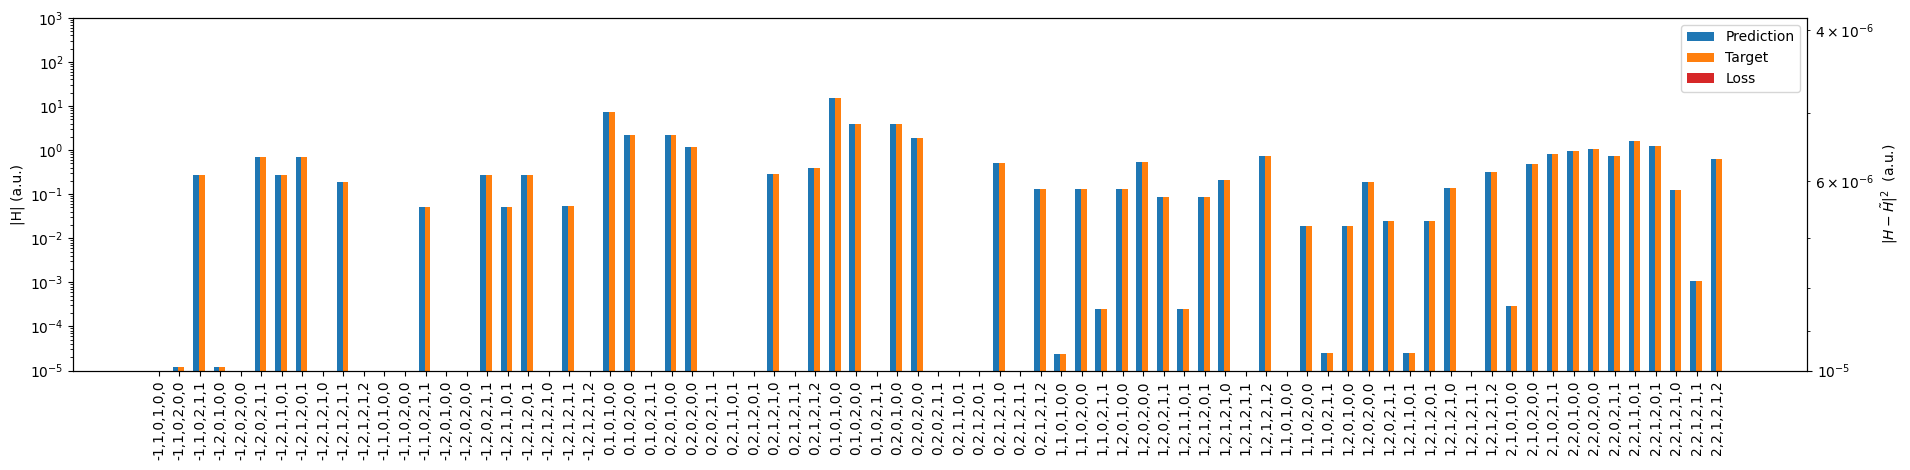

In [582]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

In [40]:
rht_ridge = blocks_to_matrix(pred_ridge_bias, dataset)
# rht_ridge1 = blocks_to_matrix(pred_ridge_bias, dataset, all_pairs= True)

In [41]:
for ifr in range(len(rht_ridge)):
    for T in rht[ifr]:
        mT = tuple(-t for t in T)
        assert torch.norm(rht_ridge[ifr][T] - rht_ridge[ifr][mT].T)<1e-12, torch.norm(rht_ridge[ifr][T] - rht_ridge[ifr][mT].T)

In [42]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
unc_pred = _to_uncoupled_basis(pred_ridge_bias)
phase, indices = precompute_phase(target_blocks, dataset, cutoff = cutoff)
pred_kspace = TMap_bloch_sums(unc_pred, phase, indices, return_tensormap=True)

In [43]:
rhk = kblocks_to_matrix(pred_kspace, dataset,)
print(torch.norm(rhk[0] - dataset.fock_kspace[0]))

tensor(15.6268)


In [583]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
      
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 512, 
                            nlayers = 0,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

model = model.double()

In [584]:
pred = model()

In [587]:
from mlelec.utils.pbc_utils import TMap_bloch_sums
from mlelec.utils.twocenter_utils import _to_uncoupled_basis

In [595]:
phase, indices = precompute_phase(_to_uncoupled_basis(pred), dataset, cutoff=cutoff)
predk=TMap_bloch_sums(_to_uncoupled_basis(pred), phase, indices, return_tensormap=True)

In [599]:
predk_mat = kblocks_to_matrix(predk, dataset)

hello tensor([[-0.0553+0.j]], grad_fn=<CloneBackward0>)


# MoS2

In [13]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'gthszvmolopt'
START = 0
STOP = 1
frames = read(f'{root}/deepH_MoS2/deepH_MoS2.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[1,1,1]]
rfock = [np.load(f"{root}/deepH_MoS2/SVB/0/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{root}/deepH_MoS2/SVB/0/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'gthszvmolopt'+'sr')

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.



In [14]:
cutoff = 50
# target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs = SORT_ORBS)
# target_blocks1, target_coupled_blocks1 = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True, sort_orbs = SORT_ORBS)

In [15]:
for ALL_PAIRS in [True, False]:
    for SORT_ORBS in [True, False]:
        try:
            kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_kspace)):
                for ik in range(len(dataset.fock_kspace[ifr])):
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS,np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except Exception as e:
            print(e)
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

True True passed
True False passed
False True passed
False False passed


In [16]:
SORT_ORBS = True
ALL_PAIRS = True

In [12]:
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)#, target='overlap')
# kblocks_S = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, target='overlap', sort_orbs=SORT_ORBS)

In [13]:
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
# rSk = kblocks_to_matrix(kblocks_S, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

In [14]:
kfock = dataset.fock_kspace
for ifr in range(len(kfock)):
    for ik in range(len(kfock[ifr])):
        # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
        print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))

7.311771605807756e-14


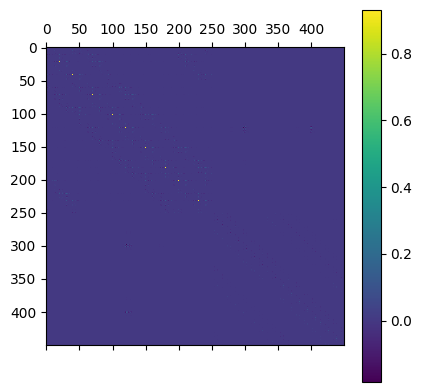

In [29]:
plt.matshow((kfock[ifr][0] -rhk[ifr][0].numpy()).real)
plt.colorbar()

In [444]:
kfock[ifr][ik][1,12],rhk[ifr][ik].numpy()[1,12]*200


(tensor(0.0570+0.j), (0.05144206335160119+0j))

In [559]:
from scipy.linalg import eigvalsh
eigactual = []
eigcut=[]
for ik in range(len(dataset.fock_kspace[0])):
    eigactual.append(eigvalsh(dataset.fock_kspace[0][ik].numpy(), dataset.overlap_kspace[0][ik].numpy()))
    eigcut.append(eigvalsh(rhk[0][ik].numpy(), rSk[0][ik].numpy()))
eigactual = np.concatenate(eigactual)
eigcut = np.concatenate(eigcut)    

(-2.0, 0.6524677627897296)

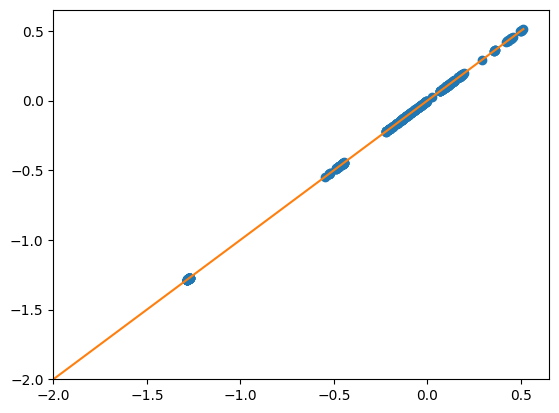

In [560]:
plt.plot(eigactual, eigcut, 'o')
plt.plot([np.min(eigactual), np.max(eigactual)],[np.min(eigactual), np.max(eigactual)])
plt.ylim(-2,)
plt.xlim(-2,)

In [36]:
blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)#, target='overlap')
blocks_S = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, target='overlap', sort_orbs=SORT_ORBS)

In [37]:
rh = blocks_to_matrix(blocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
rS = blocks_to_matrix(blocks_S, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

In [39]:
kfock = dataset.fock_realspace
for ifr in range(len(kfock)):
    for ik in kfock[ifr]:
        # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
        print(np.linalg.norm(kfock[ifr][ik]-rh[ifr][ik].numpy()))

7.307318575549316e-14
2.2662945240885274e-16
2.2662945240885274e-16
2.270770015247583e-16
2.270770015247583e-16
6.81885129995414e-17
7.496116907552587e-18
7.496116907552588e-18
6.81885129995414e-17


# Equivariance 

In [ ]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 3
frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[8,8,1], [4,4,1]]
kfock = [np.load(f"{root}/graphene_supercell_variety/fock_{i}.npy", allow_pickle = True) for i in range(START, STOP)]
kover = [np.load(f"{root}/graphene_supercell_variety/over_{i}.npy", allow_pickle = True) for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               fock_kspace = kfock, 
                               overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Graphene - UC

In [9]:
workdir = './'
START = 0 
STOP=1
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root
frames = read(f'{data_dir}/C2_174.extxyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/881/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/881/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [[12,12,1]]
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [ ]:
cutoff = 8
SORT_ORBS = True
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
target_blocks1, target_coupled_blocks1= get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True, sort_orbs = SORT_ORBS)

# Graphene - deepH

In [17]:
workdir = './'
START = 0 
STOP=1
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap/'
data_dir = root
frames = read(f'{data_dir}/wrapped_deepH_graphene.xyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [[1,1,1]]
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [18]:
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)#, target='overlap')
# kblocks_o = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, target='overlap', sort_orbs=SORT_ORBS)

In [ ]:
cutoff = 23

In [ ]:
for ALL_PAIRS in [True, False]:
    for SORT_ORBS in [True, False]:
        try:
            kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_kspace)):
                for ik in range(len(dataset.fock_kspace[ifr])):
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS)
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except:
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

True True passed


In [ ]:
cutoff = 23
SORT_ORBS = False
ALL_PAIRS = False

# target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
# target_blocks1, target_coupled_blocks1= get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True, sort_orbs = SORT_ORBS)

In [894]:
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
# rSk = kblocks_to_matrix(kblocks_o, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

In [869]:
kfock = dataset.fock_kspace
for ifr in range(len(kfock)):
    for ik in range(len(kfock[ifr])):
        # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
        print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy())/np.prod(rhk[ifr][ik].numpy().shape))

1.286063447511136e-19


In [871]:
from scipy.linalg import eigvalsh
eigactual = []
eigcut=[]
for ik in range(len(dataset.fock_kspace[0])):
    eigactual.append(eigvalsh(dataset.fock_kspace[0][ik].numpy(), dataset.overlap_kspace[0][ik].numpy()))
    eigcut.append(eigvalsh(rhk[0][ik].numpy(), rSk[0][ik].numpy()))
eigactual = np.concatenate(eigactual)
eigcut = np.concatenate(eigcut)    

ValueError: wrong b dimensions (10, 10), should be (360, 360)

ValueError: x and y must have same first dimension, but have shapes (1, 360) and (0,)

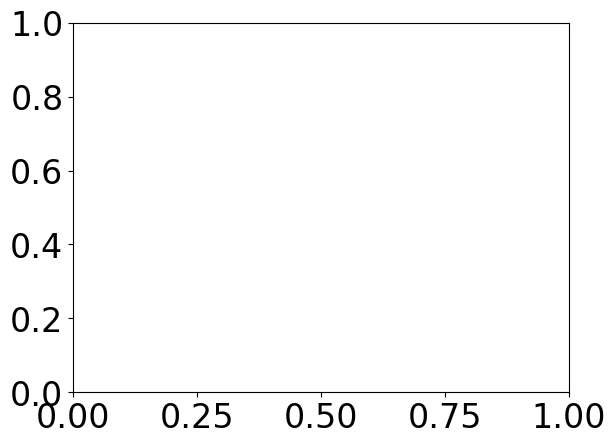

In [872]:
plt.plot(eigactual, eigcut, 'o')
plt.plot([np.min(eigactual), np.max(eigactual)],[np.min(eigactual), np.max(eigactual)])
plt.ylim(-2,)
plt.xlim(-2,)


# HEX-HEX22 - WOHOOO0 works!

In [61]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 1
STOP = 3
frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[8,8,1], [4,4,1]]
kfock = [np.load(f"{root}/graphene_supercell_variety/fock_{i}.npy", allow_pickle = True) for i in range(START, STOP)]
kover = [np.load(f"{root}/graphene_supercell_variety/over_{i}.npy", allow_pickle = True) for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               fock_kspace = kfock, 
                               overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Targets

In [62]:
cutoff = 6
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)

In [63]:
k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = False)

In [64]:
rhk =kblocks_to_matrix(k_target_blocks, dataset)
torch.norm(rhk[0] - dataset.fock_kspace[0])

tensor(2.3644e-14)

In [65]:
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion

In [66]:
rhoi = SphericalExpansion(**hypers_atom).compute(frames)
gij = PairExpansion(**hypers_pair).compute(frames)

# Features

In [68]:
import rascaline
max_radial  = 8
max_angular = 5
atomic_gaussian_width = 0.3
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

def compute_features(dataset):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  
    feature_names = rhoij.property_names
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
        
    if return_rho0ij:
        feature_names = None
        NU=1
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = feature_names)

    if return_rho0ij:
        return rhoij, rhonui
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [179]:
rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  

cpu pair features
cpu single center features
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor_1', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbo

In [143]:
rhoij.property_names

['species_neighbor', 'n_1', 'k_2', 'species_neighbor_12', 'n_12', 'l_2']

In [113]:
rho3i = single_center_features(dataset.structures, hypers_atom, order_nu = 3, lcut = 3, device = device,)
rho2i = single_center_features(dataset.structures, hypers_atom, order_nu = 2, lcut = 3, device = device,)
rho1i = single_center_features(dataset.structures, hypers_atom, order_nu = 1, lcut = 3, device = device,)
                                    

cpu single center features
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] 

In [121]:
xnuk if "species_neighbor" not in xnuk and "n_1__" not in xnuk for xnuk in rho2i.property_names

SyntaxError: expected 'else' after 'if' expression (586240782.py, line 1)

In [119]:
rho4i = single_center_features(dataset.structures, hypers_atom, order_nu = 4, lcut = 3, device = device,)


[autoreload of mlelec.features.acdc_utils_diag failed: Traceback (most recent call last):
  File "/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/nigam/miniconda3/envs/temp/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/

cpu single center features
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] ['species_neighbor', 'n_1']
(8, 2)
['species_neighbor', 'n_1'] 

In [126]:
rho1i.property_names

['species_neighbor', 'n_1']

In [122]:
rho2i.property_names

['species_neighbor', 'n_1', 'k_2', 'species_neighbor_2', 'n_2', 'l_2']

In [127]:
rho3i.property_names

['species_neighbor_a',
 'n_1_a',
 'k_2',
 'species_neighbor_b',
 'n_1_b',
 'l_2',
 'k_3',
 'species_neighbor_3',
 'n_3',
 'l_3']

In [160]:
len(rho4i.property_names)

14

In [136]:
x_a = rho1i
x_b = rho1i 
NU = x_a.keys[0]["order_nu"] + x_b.keys[0]["order_nu"]
xbnames = tuple(f'{t}_{NU}' for t in x_b.property_names) 
feature_names = (tuple(x_a.property_names) + ("k_" + str(NU),) + xbnames + ("l_" + str(NU),))

In [178]:
pnames = ['species_neighbor_1', 'n_1']
for i in range(2, 4+1):
    pnames.extend([f'k_{i}', f'species_neighbor_{i}', f'n_{i}', f'l_{i}'])

In [176]:
pnames = ('species_neighbor_1', 'n_1'])
pnames += (f'k_{i}', f'species_neighbor_{i}', f'n_{i}', f'l_{i}'] for i in range(2, 4+1)]

In [177]:
pnames

['species_neighbor_1',
 'n_1',
 ['k_2', 'species_neighbor_2', 'n_2', 'l_2'],
 ['k_3', 'species_neighbor_3', 'n_3', 'l_3'],
 ['k_4', 'species_neighbor_4', 'n_4', 'l_4']]

In [ ]:
class trial_encoder(nn.Module):
    def __init__():
        pass
    def forward():
        pass

In [69]:
hfeat = compute_features(dataset)

cpu pair features
cpu single center features
cpu single center features


In [70]:
gij.property_names

['n']

In [71]:
for k, b in gij.items():
    rhoikey = Labels(["spherical_harmonics_l", "species_center", "inversion_sigma"],[k['spherical_harmonics_l'], k['species_center'], 1
                                                                                    ])
    rhoblock = rhoi.block(rhoikey)
    rhoblock.samples.view(["center"], )
    for sample in b.samples:
        ifr,i,_ = ssample["center"]
        np.where(rhoblock)

ValueError: 'spherical_harmonics_l' not found in the dimensions of these Labels

In [16]:
# %%timeit
hfeat = compute_features(dataset)

cpu pair features
cpu single center features
cpu single center features


# Train

## Ridge regression

In [72]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [73]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [74]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -2, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(2.2922e-08)


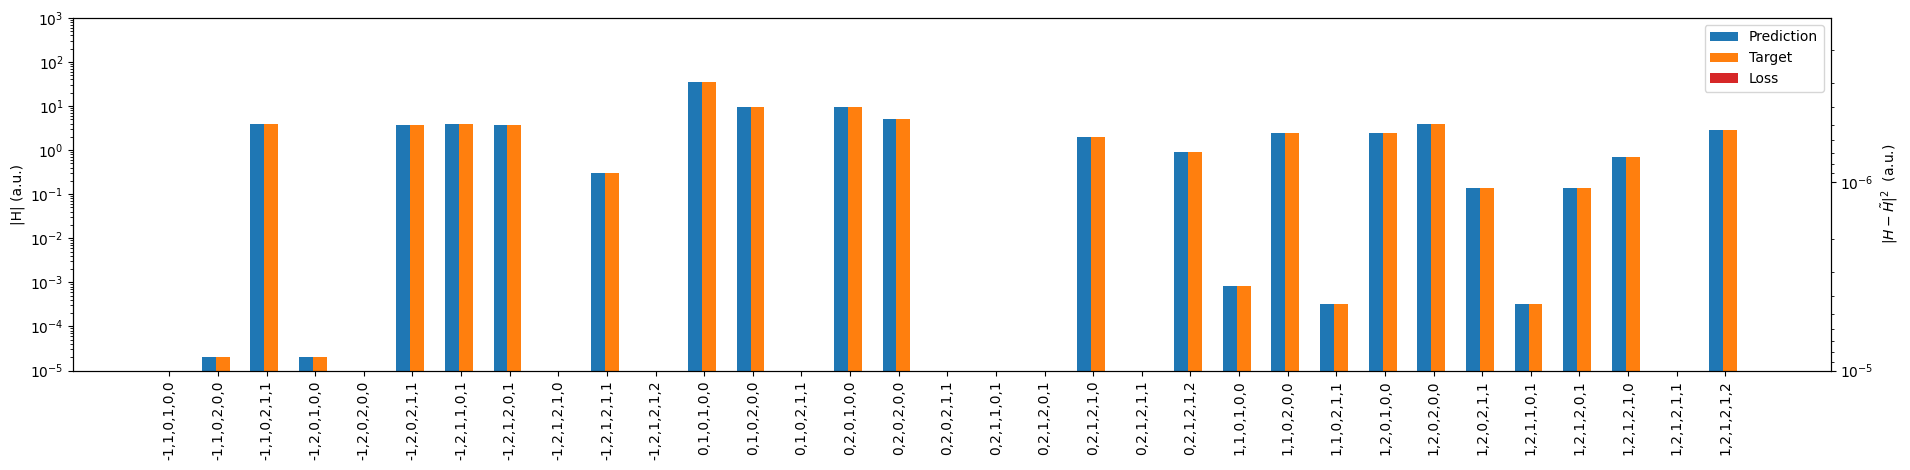

In [75]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

Compute the feature covariance matrix and diagonalize it. Project the weights onto the covariance eigenstates at each training iteration (TODO)

## Torch

In [76]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [77]:
from mlelec.models.linear import LinearModelPeriodic

In [78]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
CG = ClebschGordanReal(lmax = 3, device = device)

In [79]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 512, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model = model.double()
# for p, (_, b) in zip(model.parameters(), target_coupled_blocks.items()):
#     p.data = torch.ones_like(p.data)

losses = {}
para = {}
grad = {}
learning_rates = {}
last_layer_kernel = {}
nepoch = 1000

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=1e-1)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    # optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 1e-1)) #, betas = (0.8, 0.9)))
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-3, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 30, verbose=True))

/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [80]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

phase, indices = precompute_phase(target_blocks, dataset, cutoff = cutoff)

loss_real = []
loss_k = []

new_sched = True
for epoch in range(nepoch):

    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    
    pred = model()
    unc_pred = _to_uncoupled_basis(pred, cg = CG)
    pred_kspace = TMap_bloch_sums(unc_pred, phase, indices)
    
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 100:

        # Compute the loss for each block
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)

        # Total loss
        epoch_loss = epoch_loss.item()
        
        # Append the values of the loss to a list
        loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 2).item())
        loss_real.append(epoch_loss)

        # Loop through submodels and backpropagate
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            
            if key not in losses:
                losses[key] = [loss.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
                
    else:

        # Compute the loss
        loss = L2_loss(pred_kspace, k_target_blocks, norm = 2)

        # Total loss 
        epoch_loss = loss.item()
        
        # Append the values of the loss to a list
        all_losses, epoch_loss_real = L2_loss(pred, target_coupled_blocks, loss_per_block=True)
        loss_real.append(epoch_loss_real.item())
        loss_k.append(epoch_loss)

               
        loss.backward(retain_graph = True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        for ik, (loss_, key) in enumerate(zip(all_losses, model.model)):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss/len(model.model))
            if key not in losses:
                losses[key] = [loss_.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss_.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
        
    if epoch % 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

AssertionError: Target must be a dictionary

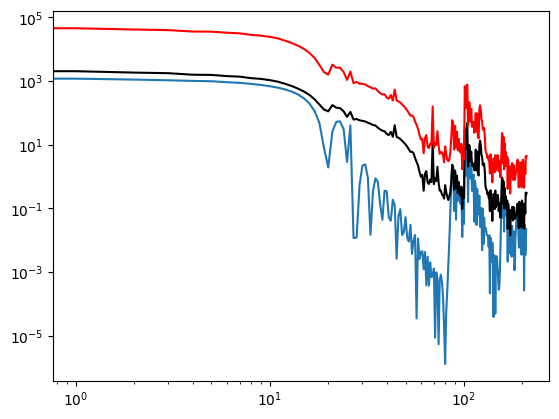

In [ ]:
for k in losses:
    if k == '(0, 6, 1, 0, 6, 1, 0, 0)':
        plt.loglog(losses[k], label = k)
# plt.ylim(1e-10)
plt.loglog(loss_real, 'k')
plt.loglog(loss_k, 'r')

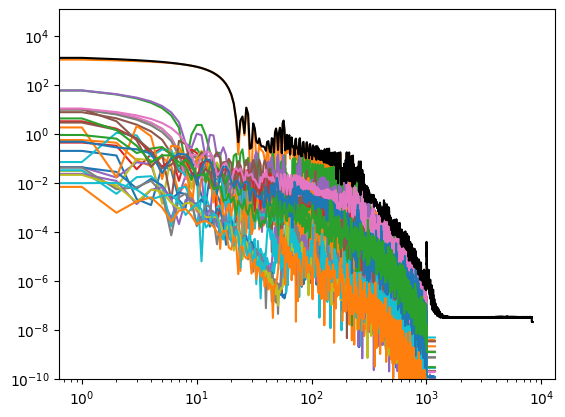

In [32]:
for k in losses:
    plt.loglog(losses[k], label = k)
plt.ylim(1e-10)
plt.loglog(loss_real, 'k')

# Bands

In [55]:
def reconstruct(pred, dataset, cutoff):
    from mlelec.utils.pbc_utils import inverse_bloch_sum
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    S = [inverse_bloch_sum(dataset, dataset.overlap_kspace[ifr], ifr, cutoff) for ifr in range(len(dataset.structures))]
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in S[ifr]:
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in S[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                print(T)
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [56]:
rH_k, rS_k = reconstruct(pred, dataset, cutoff = cutoff)

_, true_target_coupled_blocks = get_targets(dataset, cutoff = 8.35, device = device)
rH_true, rS_true = reconstruct(true_target_coupled_blocks, dataset, cutoff = 8.35)

-0.007484087355638383
-0.007498410787027821


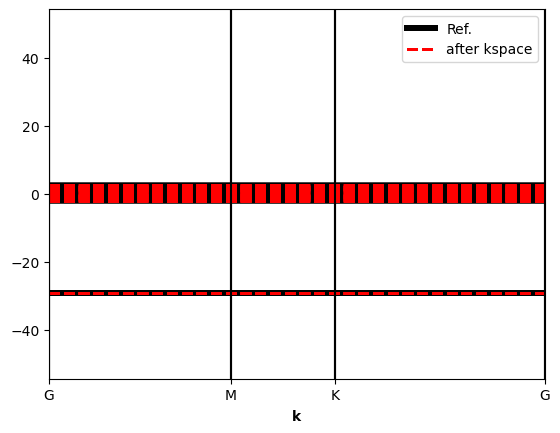

In [57]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 2
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(rH_true[ifr].values())) #np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(rS_true[ifr].values())) #np.asarray(list(dataset.overlap_realspace[0].values()))
R_vec_rel = [list(T) for T in rH_true[ifr]]

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', 
                                  factor = 1,
                                  kpath = kpath, ax = ax, color = 'k', R_vec_rel_in = R_vec_rel, lw = 3)
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_k], [rS_k], ['red'], ['--'], [1], ['after kspace']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):
    # if label == 'only real space':
        # continue
    realfock_cutoff = np.asarray(list(H[ifr].values()))
    realover_cutoff = np.asarray(list(S[ifr].values()))
    R_vec_rel = [list(T) for T in H[ifr]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh, 
                                      factor = factor,
                                      lw = 2,
                                      R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# ax.set_ylim(-35, 43)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



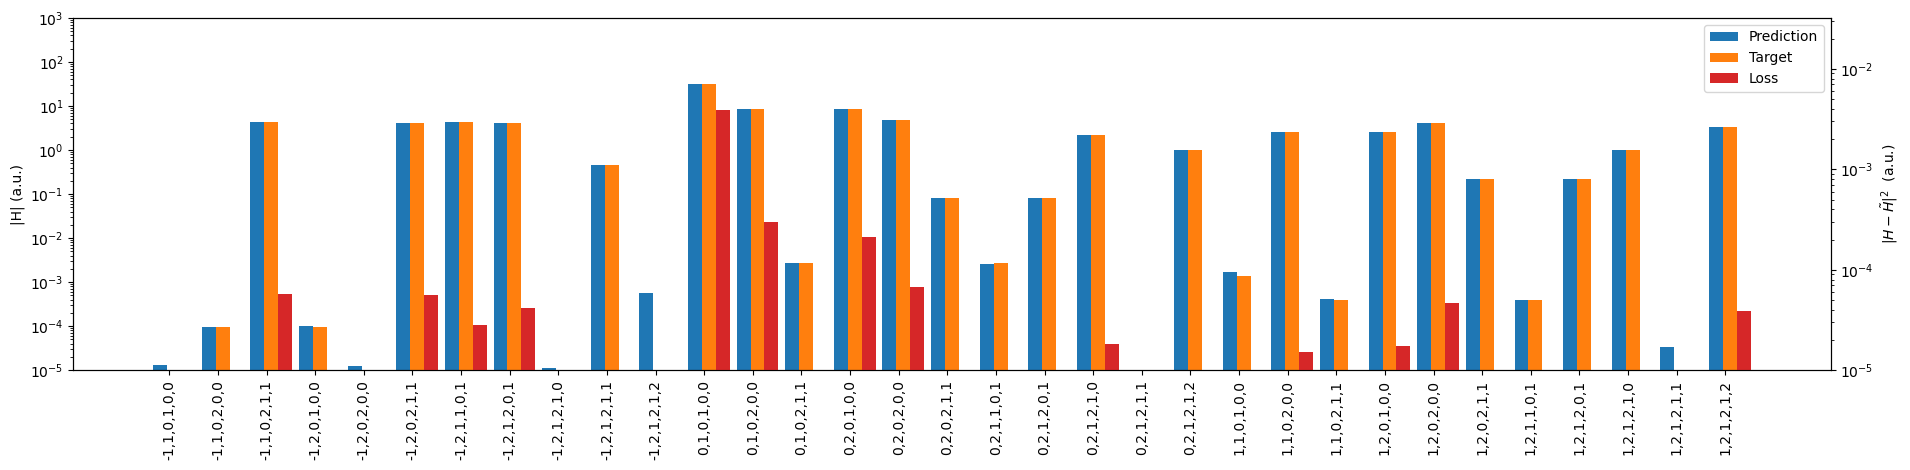